In [1]:
from enum import Enum
import functools
import os
from typing import List
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from polluters import Polluter, MissingValuePolluter, CompletenessPolluter
from pandas.api.types import is_numeric_dtype, is_string_dtype

In [ ]:
MISSING_OBJECT = "empty"
MISSING_NUMERIC_POSITIVE = -1
BASE_PATH = '../../data'

# Dataset analysis and preprocessing

## House Pricing Dataset

In [ ]:
house_df = pd.read_csv(f"{BASE_PATH}/house-prices-data/train.csv")
house_df.info()

In [ ]:
# check for existing duplicates
print(house_df.duplicated().sum())

In [ ]:
# analyse: which and columns columns have how many null values?
print(house_df.isna().sum(axis=0).sort_values(ascending=False).to_numpy().nonzero())
print(house_df.isna().sum(axis=0).sort_values(ascending=False)[:10])
print(house_df.isna().sum(axis=0).sort_values(ascending=False)[10:19])

In [ ]:
# Fill all the columns where NA actually means something according to the dataset documentation
house_df[["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageCond", "GarageType", "GarageFinish", "GarageQual", "BsmtFinType2", "BsmtExposure", "BsmtQual", "BsmtCond", "BsmtFinType1"]] \
= house_df[["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageCond", "GarageType", "GarageFinish", "GarageQual", "BsmtFinType2", "BsmtExposure", "BsmtQual", "BsmtCond", "BsmtFinType1"]].fillna("None")
house_df["GarageYrBlt"] = house_df["GarageYrBlt"].fillna(0)

In [ ]:
# check which columns still have null values
print(house_df.isna().sum(axis=0).sort_values(ascending=False)[:10])

In [ ]:
# check whether missing MasNvrType values are related to the area
print(house_df.loc[house_df["MasVnrType"].isna()][["MasVnrType", "MasVnrArea"]])
print(house_df.loc[house_df["MasVnrArea"] == 0.0][["MasVnrType", "MasVnrArea"]])

In [ ]:
# discard Id because it is unique per example anyway
attr_to_discard = ['Id']
house_df = house_df.drop(columns=attr_to_discard)
house_df.info()

In [ ]:
# fill null (=remaining missing values) with placeholder values: -1 (for numeric) or "empty" (for categoric, which means type object)
house_df[house_df.select_dtypes("object").columns] = house_df.select_dtypes("object").fillna(MISSING_OBJECT)
house_df[house_df.select_dtypes(exclude="object").columns] = house_df.select_dtypes(exclude="object").fillna(MISSING_NUMERIC_POSITIVE)
house_df.info()

In [ ]:
house_df["SalePrice"] = house_df["SalePrice"].astype(float)
house_df.info()

In [ ]:
house_df.to_csv(f"{BASE_PATH}/clean/house_prices_prepared.csv", index=False)

## Add house metadata

In [ ]:
# some categorical attributes are already stored as integers, but they are inherently categorical, so they have to be stored in the metadata as categorical
house_categorical_attr = list(house_df.select_dtypes("object").columns)
house_categorical_attr += ['MSSubClass', 'OverallQual', 'OverallCond']
print(house_categorical_attr)
print(len(house_categorical_attr))

house_numeric_attr = list(house_df.select_dtypes(np.number).columns.difference(house_categorical_attr + ["SalePrice"]))
print(house_numeric_attr)
print(len(house_numeric_attr))

In [ ]:
# check whether the default placeholder values are not already present in the dataset except for the cases where we already know that a value is missing
print((house_df[house_df.select_dtypes("object").columns] == MISSING_OBJECT).sum())
print((house_df[house_df.select_dtypes(np.number).columns] < 0).sum())

In [ ]:
categorical_defaults = {col: MISSING_OBJECT for col in house_categorical_attr}
# Use -1 for categories represented as integers
for col in ['MSSubClass', 'OverallQual', 'OverallCond']:
    categorical_defaults[col] = MISSING_NUMERIC_POSITIVE
print(categorical_defaults)

In [ ]:
# look at histogram with discretized target attribute, as this is required for some polluters
plt.hist(house_df["SalePrice"], bins=np.arange(800000, step=100000))

# Car dataset

In [ ]:
car_df = pd.read_csv(f'{BASE_PATH}/clean/vw.csv')
car_df.info()

# check for existing duplicates
print(car_df.duplicated().sum())
# no missing values or id columns, so we can use the dataset as it is

In [ ]:
car_df["price"] = car_df["price"].astype(float)
car_df.info()

In [ ]:
car_df.to_csv(f"{BASE_PATH}/clean/vw_prepared.csv", index=False)

## Add car Metadata

In [ ]:
# check whether there are already missing values (with values that can be used as placeholder) and whether we can use -1 as placeholder for integer
for col in car_df.columns:
    print(car_df[col].unique())
print((car_df[car_df.select_dtypes(np.number).columns] < 0).sum())

In [ ]:
# look at histogram with discretized target attribute, as this is required for some polluters
plt.hist(car_df["price"], bins=np.arange(70000, step=10000))

# IMDB dataset

In [ ]:
imdb_df = pd.read_csv(f'{BASE_PATH}/clean/imdb.csv')
imdb_df.info()

In [ ]:
# discard all samples where the target is missing, convert string columns to number
imdb_df = imdb_df.loc[imdb_df["Rate"] != "No Rate"]
imdb_df["Rate"] = imdb_df["Rate"].astype(float)
imdb_df["Votes"] = imdb_df["Votes"].str.replace(',', '').astype(int)
imdb_df.info()

# check for existing duplicates
print(imdb_df.duplicated().sum())

In [ ]:
# change duration missing value to make it usable as number
imdb_df["Duration"].loc[imdb_df["Duration"] == "None"] = MISSING_NUMERIC_POSITIVE
imdb_df["Duration"] = imdb_df["Duration"].astype(int)

In [ ]:
# check whether the episodes attribute is - only for films
imdb_df.loc[imdb_df["Episodes"] == "-"].loc[imdb_df["Type"] != "Film"]

In [ ]:
# Set number of episodes for films to 0 to make it usable as number,
# distinguish from -1 placeholder value because the - is related to the sample being a film
imdb_df["Episodes"].loc[imdb_df["Episodes"] == "-"] = 0
imdb_df["Episodes"] = imdb_df["Episodes"].astype(int)

# discard name column because each (unique) sample has its own name
imdb_df = imdb_df.drop(columns="Name")
imdb_df.info()

In [ ]:
imdb_df.to_csv(f'{BASE_PATH}/clean/imdb_prepared.csv', index=False)

## Add IMDB metadata

In [ ]:
# check whether there are already missing values (with values that can be used as placeholder) and whether we can use -1 as placeholder for integer
for col in imdb_df:
    print(np.sort(imdb_df[col].unique()))

In [ ]:
# look at histogram with discretized target attribute, as this is required for some polluters
plt.hist(imdb_df["Rate"], bins=np.arange(11, step=1))

In [3]:
bank_df = pd.read_csv("../data/clean/bank.csv")

Text(0.5, 1.0, 'Histogram of Duplicates for Bank Dataset')

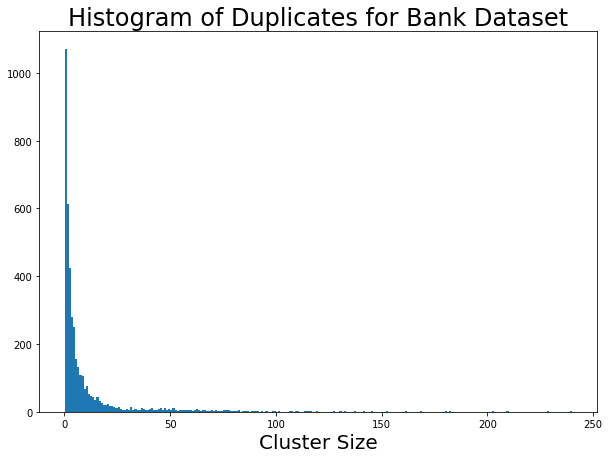

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
target_count = bank_df.groupby(bank_df.columns.tolist(), as_index=False).size()
axes.hist(target_count['size'], bins=np.arange(0.1, max(target_count['size'])+1))
axes.set_xlabel('Cluster Size', size=20)
axes.set_title('Histogram of Duplicates for Bank Dataset', size=24)